# Under-Representation Bias

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy

# Data + EDA

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = [], sep = '', synthetic = False):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        if not synthetic:
            self.df = pd.read_csv(path, sep = sep)

### Popular Datasets

In [3]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [4]:
# example - adding a dataset and cleaning it
path_adult_income = 'Datasets/adult.csv'

# note, cat_cols doesn't include predictor - income
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols, sep = ",")
add_dataset(adult_income)

In [5]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num, sep = ";"))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num, sep = ";"))

### Synthetic Dataset

#### Data Generation

50.7 % positively labeled


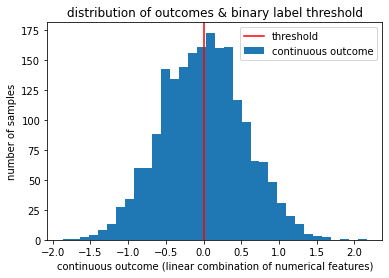

In [6]:
## create synthetic data as such:
# 3 numerical features (Gaussian), 1 categorical (sensitive attribute), 
# linear outcome model, s.t. outcome = Ind[effect_param*features > threshold]

# parameters
threshold = 0 # binary label threshold (outcome > threshold => label=1, else 0)
effect_param = [0.5, -0.2, 0.1] # causal effect parameter (to create outcomes)
n = 2000 # sample size
prop_noise = 0.01 # proportion of noisy binary labels (set to 0 for totally linear)

# categorical feature params
# required: len(cat_probabilities) = n_cat_features
n_cat_features = 2
cat_probabilities = [0.5, 0.5] 

# numerical feature params
num_feature_mean = [0, 0, 0]
num_feature_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# features
num_features = np.random.multivariate_normal(num_feature_mean, num_feature_cov, n)
cat_features = np.random.choice(np.arange(n_cat_features), n, cat_probabilities).reshape(n,1)

# outcomes
outcome_continuous = np.matmul(num_features,effect_param) # linear + no added noise
outcome_binary = np.where(outcome_continuous > threshold, 1, 0).reshape(n,1)

# binary label noise (flip prop_noise labels)
flip_idx = np.random.randint(0,n,int(n*prop_noise))
outcome_binary[flip_idx] = (outcome_binary[flip_idx]-1)*-1

# joint = [numerical features, categorical features, & binary outcome]
joint = np.hstack((num_features, cat_features, outcome_binary))

# print pct of positive labels (to check threshold)
print(round(np.mean(outcome_binary)*100,2), "% positively labeled")

# plot distribution of continuous outcomes & binary threshold 
plt.hist(np.matmul(num_features,effect_param),label='continuous outcome',bins='auto')
plt.axvline(threshold,color='red',label='threshold')
plt.xlabel("continuous outcome (linear combination of numerical features)")
plt.ylabel("number of samples")
plt.title("distribution of outcomes & binary label threshold")
plt.legend()
plt.show()

In [7]:
## add synthetic data to dataset list

# save to file
df_gaussian_synthetic = pd.DataFrame(pd.DataFrame(joint))
df_gaussian_synthetic.columns = ['num1','num2','num3','cat','outcome']
path_gaussian_synthetic = 'Datasets/gaussian_synthetic.csv'
df_gaussian_synthetic.to_csv(path_gaussian_synthetic)

# define Dataset object
cat = df_gaussian_synthetic.columns.values[-1]
num = df_gaussian_synthetic.columns.values[:-2]
gaussian_synthetic = Dataset('gaussian_synthetic', path_gaussian_synthetic, cat_cols=cat, num_cols=num, synthetic=True)

# add to dataset list
add_dataset(gaussian_synthetic)

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [8]:
df_por = datasets['student_por'].df

df_adult = datasets['adult_income'].df
df_adult = df_adult.replace('?', np.NaN)
#print(df_adult.shape)
df_adult = df_adult.dropna()
#print(df_adult.shape)
#df_adult.head()

df_synthetic = df_gaussian_synthetic
#df_synthetic.head()

In [9]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [10]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [11]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [12]:
# Adult

df_adult["label"] = df_adult["income"].map({'<=50K':0,">50K":1})

df_adult["label"].value_counts()

0    34014
1    11208
Name: label, dtype: int64

In [13]:
# Student Performance

def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
threshold(df_por, threshold=14)
df_por['pass'].value_counts()

0    512
1    137
Name: pass, dtype: int64

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [14]:
sens_attrs_por = [df_por['sex'], df_por['address']]
sens_attrs_adult = [df_adult['gender'], df_adult['race']]
sens_attrs_syn = [df_synthetic['cat']]

### Data Preprocessing

In [15]:
# format data

X_por = df_por.iloc[:, :-2].values
y_por = df_por.iloc[:, -1].values

X_adult = df_adult.iloc[:, :-2].values
y_adult = df_adult.iloc[:, -1].values

X_syn = df_synthetic.iloc[:, :-1].values
y_syn = df_synthetic.iloc[:, -1].values

In [16]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols_por = get_cat_cols(datasets['student_por'])
cat_cols_adult = get_cat_cols(datasets['adult_income'])

ct_por = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols_por)], remainder='passthrough')

X_por = np.array(ct_por.fit_transform(X_por))

In [17]:
df_temp = df_adult.copy().drop("income", axis = 1)
df_temp = df_temp.drop("label", axis = 1)
#print("Before", df_temp.shape)

for cat_col in datasets['adult_income'].cat_cols:
    encoded = pd.get_dummies(df_temp[cat_col])
    df_temp = df_temp.drop(cat_col, axis = 1)
    df_temp = df_temp.join(encoded)

#print("After", df_temp.shape)

df_temp = df_temp.join(df_adult['label'])

X_adult = np.array(df_temp.drop('label', axis = 1).values)

In [18]:
X_por_true = X_por
y_por_true = df_por['pass']

X_adult_true = X_adult
y_adult_true = df_adult['label']


X_syn_true = X_syn
y_syn_true = y_syn

# Bias Injection

### Class Distribution Visualization

In [19]:
#df_por.shape
print(df_por['address'].value_counts(), "\n")
print(df_por['sex'].value_counts(), "\n")

print(df_adult['race'].value_counts(), "\n")
print(df_adult['gender'].value_counts())

U    452
R    197
Name: address, dtype: int64 

F    383
M    266
Name: sex, dtype: int64 

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64 

Male      30527
Female    14695
Name: gender, dtype: int64


<AxesSubplot:>

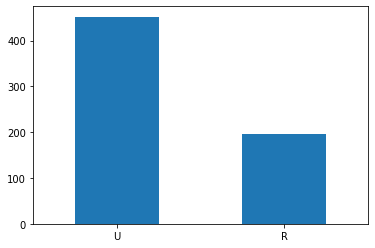

In [20]:
count = pd.value_counts(df_por['address'], sort = True)
count.plot(kind = 'bar', rot = 0)

### Bias Injection

In [21]:
# separate based on protected attribute
sens_values = sens_attrs_por[1].unique()

# TODO - add prompt for user to specify which value is favored and which is unfavored

df_favored_por = df_por[df_por['address'] == 'U']
df_unfavored_por = df_por[df_por['address'] == 'R']

df_favored_adult = df_adult[df_adult['gender'] == 'Male']
df_unfavored_adult = df_adult[df_adult['gender'] == 'Female']

df_favored_syn = df_synthetic[df_synthetic['cat'] == 0]
df_unfavored_syn = df_synthetic[df_synthetic['cat'] == 1]

In [22]:
# unfavored group with negative label
df_unfavored_por_negative = df_unfavored_por[df_unfavored_por['pass'] == 0]
df_unfavored_adult_negative = df_unfavored_adult[df_unfavored_adult['label'] == 0]
df_unfavored_syn_negative = df_unfavored_syn[df_unfavored_syn['outcome'] == 0.0]


# unfavored group with positive label (preferred)
df_unfavored_por_positive = df_unfavored_por[df_unfavored_por['pass'] == 1]
df_unfavored_adult_positive = df_unfavored_adult[df_unfavored_adult['label'] == 1]
df_unfavored_syn_positive = df_unfavored_syn[df_unfavored_syn['outcome'] == 1.0]

# differences in label counts for unfavored group
df_unfavored_por['pass'].value_counts()

df_total_por = pd.concat([df_favored_por, df_unfavored_por_negative])
df_total_adult = pd.concat([df_favored_adult, df_unfavored_adult_negative])
df_total_syn = pd.concat([df_favored_syn, df_unfavored_syn_negative])

### Under-Sampling Process

In [23]:
# under-sampling process
df_undersampled_por = df_unfavored_por_positive.sample(n=31, random_state=42)
df_undersampled_adult = df_unfavored_adult_positive.sample(n=int(len(df_unfavored_adult_positive)*0.9), random_state=42)
df_undersampled_syn = df_unfavored_syn_positive.sample(n=int(len(df_unfavored_syn_positive)*0.9), random_state=42)

# combine undersampled and original favored class to create dataset
df_concat_por = pd.concat([df_total_por,df_undersampled_por])
df_concat_adult = pd.concat([df_total_adult,df_undersampled_adult])
df_concat_syn = pd.concat([df_total_syn,df_undersampled_syn])
#print(df_concat.shape)

# for fairness measures later
df_sens_por = df_concat_por['address']
df_sens_adult = df_concat_adult['gender']
df_sens_syn = df_concat_syn['cat']

# format data
X_por_bias = df_concat_por.iloc[:, :-2].values
y_por_bias = df_concat_por.iloc[:, -1].values
X_adult_bias = df_concat_adult.iloc[:, :-2].values
y_adult_bias = df_concat_adult.iloc[:, -1].values
X_syn_bias = df_concat_syn.iloc[:, :-1].values
y_syn_bias = df_concat_syn.iloc[:, -1].values

# OHE
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols_por)], remainder='passthrough')
X_por_bias_true = np.array(ct.fit_transform(X_por_bias))
y_por_bias_true = df_concat_por['pass']


df_temp = df_concat_adult.copy().drop("income", axis = 1)
df_temp = df_temp.drop("label", axis = 1)

for cat_col in datasets['adult_income'].cat_cols:
    encoded = pd.get_dummies(df_temp[cat_col])
    df_temp = df_temp.drop(cat_col, axis = 1)
    df_temp = df_temp.join(encoded)

df_temp = df_temp.join(df_concat_adult['label'])

X_adult_bias_true = np.array(df_temp.drop('label', axis = 1).values)
y_adult_bias_true = df_concat_adult['label']


X_syn_bias_true = X_syn_bias
y_syn_bias_true = y_syn_bias

print(X_por_true.shape, X_por_bias_true.shape)
print(X_adult_true.shape, X_adult_bias_true.shape)
print(X_syn_true.shape, X_syn_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())

(649, 58) (649, 58)
(45222, 104) (45055, 104)
(2000, 4) (1949, 4)



### Post-Injection Visualization

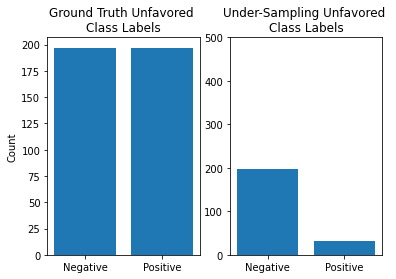

In [25]:
positive = len(df_unfavored_por['pass'] == 0)
true_positive = len(df_unfavored_por['pass'] == 1)
bias_positive = len(df_undersampled_por)

x_vals = ['Negative', "Positive"]
y_vals_true = [positive, true_positive]
y_vals_bias = [positive, bias_positive]

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_true)
plt.title("Ground Truth Unfavored \nClass Labels")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_bias)
plt.title("Under-Sampling Unfavored \nClass Labels")
plt.ylim([0,500])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [58]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 42)

# Student Performance
classifier_por_true = classifier.fit(X_por_true, y_por_true)
y_por_pred_truth = classifier_por_true.predict(X_por_true)

classifier_por_bias = classifier.fit(X_por_bias_true, y_por_bias_true)
y_por_pred_bias = classifier_por_bias.predict(X_por_bias_true)
y_por_pred_bias_on_true = classifier_por_bias.predict(X_por_true)


# Adult Income
classifier_adult_true = classifier.fit(X_adult_true, y_adult_true)
y_adult_pred_truth = classifier_adult_true.predict(X_adult_true)

classifier_adult_bias = classifier.fit(X_adult_bias_true, y_adult_bias_true)
y_adult_pred_bias = classifier_adult_bias.predict(X_adult_bias_true)
y_adult_pred_bias_on_true = classifier_adult_bias.predict(X_adult_true)


# Synthetic Data
classifier_syn_true = classifier.fit(X_syn_true, y_syn_true)
y_syn_pred_truth = classifier_syn_true.predict(X_syn_true)

classifier_syn_bias = classifier.fit(X_syn_bias_true, y_syn_bias_true)
y_syn_pred_bias = classifier_syn_bias.predict(X_syn_bias_true)
y_syn_pred_bias_on_true = classifier_syn_bias.predict(X_syn_true)

### Model Performance (TODO: modularize)

In [59]:
print("Student Performance")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_por_pred_truth, y_por_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_por_pred_bias, y_por_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_por_pred_bias_on_true, y_por_true))

print("\nAdult Income")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_adult_pred_truth, y_adult_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_adult_pred_bias, y_adult_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_adult_pred_bias_on_true, y_adult_true))

print("\nSynthetic Data")

print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_syn_pred_truth, y_syn_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_syn_pred_bias, y_syn_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_syn_pred_bias_on_true, y_syn_true))

Student Performance
Accuracy of Ground Truth Model on Ground Truth Data:  0.9938366718027735
Accuracy of Biased Model on Biased Data:  0.9984591679506933
Accuracy of Biased Model on Ground Truth Data:  0.9984591679506933

Adult Income
Accuracy of Ground Truth Model on Ground Truth Data:  0.9780858873999381
Accuracy of Biased Model on Biased Data:  0.9778714904006215
Accuracy of Biased Model on Ground Truth Data:  0.9762283844146654

Synthetic Data
Accuracy of Ground Truth Model on Ground Truth Data:  0.9925
Accuracy of Biased Model on Biased Data:  0.995382247306311
Accuracy of Biased Model on Ground Truth Data:  0.9955


In [ ]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Thus, we can see that there is a **5% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

In [ ]:
# Biased Model on Biased Data

gm_bias = MetricFrame(accuracy_score, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

print("\n")

sr_bias = MetricFrame(selection_rate, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Thus, we can see that there is now a **7% discrepancy due to under-sampling** in the selection rate for Rural vs Urban students (with Urban students being preferred) on biased data

In [ ]:
# Biased Model on Ground Truth Data

gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

print("\n")

sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Thus, we see that the biased model has lower overall and subgroup accuracy on the ground truth data. 
Also, we can observe that the selection rate disparity increased ever so slightly with the biased model.

In [ ]:
print("Ground Truth Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("\n")

print("Biased Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

# Fairness Intervention

In [36]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
np.random.seed(0)

In [60]:
constraint = EqualizedOdds()
mitigator_por_true = ExponentiatedGradient(classifier_por_true, constraint)
mitigator_por_true.fit(X_por_true, y_por_true, sensitive_features = sens_attrs_por[1])
y_por_pred_mitigated_true = mitigator_por_true.predict(X_por_true)

In [61]:
constraint = EqualizedOdds()
mitigator_por_bias = ExponentiatedGradient(classifier_por_bias, constraint)
mitigator_por_bias.fit(X_por_bias_true, y_por_bias_true, sensitive_features = df_sens_por)
y_por_pred_mitigated_bias = mitigator_por_bias.predict(X_por_bias_true)
y_por_pred_mitigated_bias_on_true = mitigator_por_bias.predict(X_por_true)

In [62]:
constraint = EqualizedOdds()
mitigator_adult_true = ExponentiatedGradient(classifier_adult_true, constraint)
mitigator_adult_true.fit(X_adult_true, y_adult_true, sensitive_features = sens_attrs_adult[0])
y_adult_pred_mitigated_true = mitigator_adult_true.predict(X_adult_true)

In [ ]:
constraint = EqualizedOdds()
mitigator_adult_bias = ExponentiatedGradient(classifier_adult_bias, constraint)
mitigator_adult_bias.fit(X_adult_bias_true, y_adult_bias_true, sensitive_features = df_sens_adult)
y_adult_pred_mitigated_bias = mitigator_adult_bias.predict(X_adult_bias_true)
y_adult_pred_mitigated_bias_on_true = mitigator_adult_bias.predict(X_adult_true)

# Evaluation

In [ ]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [56]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_por_pred_mitigated_true, y_por_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_por_pred_mitigated_bias_on_true, y_por_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  1.0
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  1.0


In [57]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_adult_pred_mitigated_true, y_adult_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_adult_pred_mitigated_bias_on_true, y_adult_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.984808279156163
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.9863340851797797


In [ ]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

In [ ]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(selection_rate, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Hence, we observe an increase in overall and subgroup accuracy, but a decrease in disadvantaged subgroup selection rate

### Bias vs Accuracy vs Fairness Trade-Off

In [ ]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(classifier, apply_fairness = False, verbose = False):
    
    bias_amts = list(range(0,30))
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []
    eod_on_true = []
    eod_on_biased = []
    dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
    dataset_size_bias = []
    table = []

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

    for i in range(30):
        # under-sampling process
        if i == 0:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
        else:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled)-1, random_state=42)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored,df_undersampled])
        df_concat.shape
        df_sens = df_concat['address']

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        # OHE
        ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
        X_bias_true = np.array(ct.fit_transform(X_bias))
        y_bias_true = df_concat['pass']

        dataset_size_bias.append(X_bias_true.shape[0])
        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = EqualizedOdds()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        '''
        # fairness performance (TODO)
        eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
        eod_on_true.append(eod_true)

        eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
        eod_on_biased.append(eod_bias_on_true)

        # table visualization 
        table_elem = [i*10, acc_bias, acc_bias_on_true]
        table.append(table_elem)
        '''
        
        if verbose:
            print("Finished Iteration: ", len(df_concat))

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated

In [ ]:
def accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.title("Biased Model Accuracy")
        plt.ylim(0.97, 0.99)
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
        plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Dataset Size")
        plt.legend()

        plt.show()

In [ ]:
bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = tradeoff_visualization(classifier, False, False)

In [ ]:
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

In [ ]:
bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated = tradeoff_visualization(classifier, True, False)

In [ ]:
# without fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, False)

In [ ]:
# with fairness intervention
accuracy_visualizations(bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, accuracy_on_biased_mitigated, accuracy_on_true_mitigated, True)

### Special Visualizations

In [ ]:
bias_amts = list(range(0,30))
accuracy_on_true = []
accuracy_on_biased = []
accuracy_on_true_mitigated = []
accuracy_on_biased_mitigated = []
eod_on_true = []
eod_on_biased = []
eod_on_true_mitigated = []
dataset_size_true = np.full(shape=len(bias_amts), fill_value= X_true.shape[0]).tolist()
dataset_size_bias = []

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

df_undersampled = df_unfavored_positive.sample(n=len(df_unfavored_positive), random_state=42)

for i in range(30):
    # under-sampling process
    # print(len(df_undersampled))
    if i == 0:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
    else:
        df_undersampled = df_undersampled.sample(n=len(df_undersampled)-1, random_state=42)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_favored,df_undersampled])
    df_concat.shape
    df_sens = df_concat['address']

    # format data
    X_bias = df_concat.iloc[:, :-2].values
    y_bias = df_concat.iloc[:, -1].values

    # OHE
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
    X_bias_true = np.array(ct.fit_transform(X_bias))
    y_bias_true = df_concat['pass']

    dataset_size_bias.append(X_bias_true.shape[0])
    classifier_bias = classifier.fit(X_bias_true, y_bias_true)

    constraint = EqualizedOdds()
    classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
    
    # model testing
    
    # on biased data
    
    # without fairness intervention
    y_pred_bias = classifier_bias.predict(X_bias_true)
    # with fairness intervention
    y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
    
    # on GT data
    
    # without fairness intervention
    y_pred_bias_on_true = classifier_bias.predict(X_true)
    # with fairness intervention
    y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
    
    
    # model performance
    
    # on biased data
    
    # without fairness intervention
    acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
    accuracy_on_biased.append(acc_bias)
    # with fairness intervention
    acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
    accuracy_on_biased_mitigated.append(acc_bias_mitigated)
    
    # on GT data
    
    # without fairness intervention
    acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
    accuracy_on_true.append(acc_bias_on_true)
    # with fairness intervention
    acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
    accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)

    # fairness performance
    
    eod_true = equalized_odds_difference(y_true=y_bias_true, y_pred = y_pred_bias, sensitive_features=df_sens)
    eod_on_true.append(eod_true)

    eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_biased.append(eod_bias_on_true)
    
    eod_bias_true_mitigated = equalized_odds_difference(y_true=y_true, y_pred = y_pred_mitigated_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_true_mitigated.append(eod_bias_true_mitigated)
    

In [ ]:
plt.figure(figsize=(17,7))

plt.subplot(1,2,1)
plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Accuracy Score")
#plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
plt.title("Accuracy of Biased Model (trained on biased data)")
plt.ylim(0.9725, 0.99)
plt.legend()

plt.subplot(1,2,2)
plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Dataset Size")
plt.title("Amount of Minority Samples Removed vs Dataset Size")
plt.legend()

plt.show()

In [ ]:
plt.plot(bias_amts, eod_on_biased, label = 'On Biased Data + No Fairness Intervention', color = "red")
plt.plot(bias_amts, eod_on_true, label = 'On Ground Truth + No Fairness Intervention', color = "blue")
plt.plot(bias_amts, eod_on_true_mitigated, label = 'On Ground Truth + Fairness Intervention', color = "purple")
plt.xlabel("Amount of Bias (number of minority samples removed)")
plt.ylabel("Equalized Odds Difference")
plt.axhline(y=equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]), color = "green",
            label = "Ground Truth EOD", alpha = 0.5)
plt.ylim(0, 0.15)
plt.legend()
plt.title("Biased Model Equalized Odds Difference")
plt.show()
#plt.savefig("bias1.png")